# Machine Learning For Market Trading

In [656]:
import pandas as pd
from matplotlib import pyplot as plt

In [657]:
df = pd.read_excel('candlestick_data.xlsx', index_col=0, sheet_name='Sheet2')
df.head(3)

,open,high,low,close,Currency
Dates,,,,,
2000-01-03,9.498,9.5050,9.341,9.5050,USDMXN
2000-01-04,9.403,9.5713,9.403,9.5713,USDMXN
2000-01-05,9.580,9.6100,9.505,9.5710,USDMXN


In [658]:
df = df[df["Currency"] == "USDMXN"]

In [659]:
#Check if NA values are in data
df.reset_index(inplace=True)
# df = df[(df["Dates"] >= "2008-01-01") & (df["Dates"] <= "2019-12-31")]
# df.reset_index(drop=True,inplace=True)
df.head()

,Dates,open,high,low,close,Currency
0,2000-01-03,9.498,9.5050,9.3410,9.5050,USDMXN
1,2000-01-04,9.403,9.5713,9.4030,9.5713,USDMXN
2,2000-01-05,9.580,9.6100,9.5050,9.5710,USDMXN
3,2000-01-06,9.545,9.6100,9.5365,9.5800,USDMXN
4,2000-01-07,9.610,9.6100,9.4788,9.5650,USDMXN


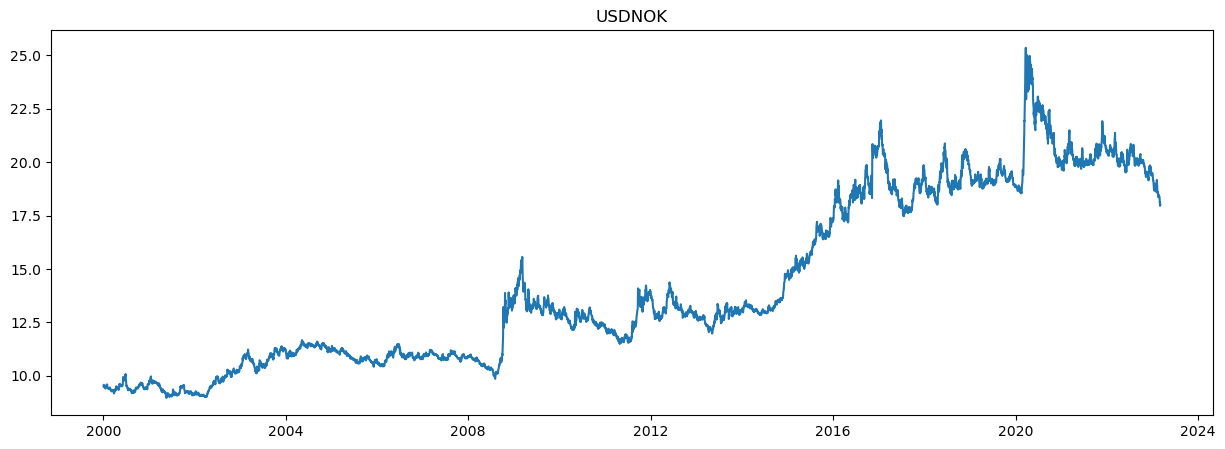

In [660]:
plt.figure(figsize=(15,5))
plt.plot(df["Dates"], df["close"])
plt.title("USDNOK")
plt.show()

# Support and Resistance FUNCTIONS

In [661]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1

In [662]:
length = len(df)
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
open = list(df['open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.high[l]-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c2 = abs(max(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c3 = min(df.open[l],df.close[l])<min(levels, key=lambda x:abs(x-df.high[l]))
    c4 = df.low[l]<min(levels, key=lambda x:abs(x-df.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.low[l]-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c2 = abs(min(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c3 = max(df.open[l],df.close[l])>min(levels, key=lambda x:abs(x-df.low[l]))
    c4 = df.high[l]>min(levels, key=lambda x:abs(x-df.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [663]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [664]:
df['signal']=signal

In [665]:
df[df['signal']==1].count()

Dates       134
open        134
high        134
low         134
close       134
Currency    134
signal      134
dtype: int64

In [666]:
df

,Dates,open,high,low,close,Currency,signal
0,2000-01-03,9.4980,9.5050,9.3410,9.5050,USDMXN,0
1,2000-01-04,9.4030,9.5713,9.4030,9.5713,USDMXN,0
2,2000-01-05,9.5800,9.6100,9.5050,9.5710,USDMXN,0
3,2000-01-06,9.5450,9.6100,9.5365,9.5800,USDMXN,0
4,2000-01-07,9.6100,9.6100,9.4788,9.5650,USDMXN,0
...,...,...,...,...,...,...,...
6041,2023-02-28,18.3688,18.4177,18.2821,18.3057,USDMXN,0
6042,2023-03-01,18.3057,18.3316,18.0706,18.1154,USDMXN,0
6043,2023-03-02,18.1157,18.1936,18.0940,18.1259,USDMXN,0
6044,2023-03-03,18.1259,18.1259,17.9488,17.9570,USDMXN,0


In [667]:
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close','Currency', 'signal']
#df=df.iloc[100:200]
df

,Local time,Open,High,Low,Close,Currency,signal
0,2000-01-03,9.4980,9.5050,9.3410,9.5050,USDMXN,0
1,2000-01-04,9.4030,9.5713,9.4030,9.5713,USDMXN,0
2,2000-01-05,9.5800,9.6100,9.5050,9.5710,USDMXN,0
3,2000-01-06,9.5450,9.6100,9.5365,9.5800,USDMXN,0
4,2000-01-07,9.6100,9.6100,9.4788,9.5650,USDMXN,0
...,...,...,...,...,...,...,...
6041,2023-02-28,18.3688,18.4177,18.2821,18.3057,USDMXN,0
6042,2023-03-01,18.3057,18.3316,18.0706,18.1154,USDMXN,0
6043,2023-03-02,18.1157,18.1936,18.0940,18.1259,USDMXN,0
6044,2023-03-03,18.1259,18.1259,17.9488,17.9570,USDMXN,0


In [668]:
def SIGNAL():
    return df.signal

In [669]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, 
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), 
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True). 
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin 
#with more fine-grained (e.g. hourly) data.

In [670]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 600e-4
            tp1 = self.data.Close[-1] + 450e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 600e-4
            tp1 = self.data.Close[-1] - 450e-4
            self.sell(sl=sl1, tp=tp1)

In [671]:
from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00, exclusive_orders=True)
stat = bt.run()
pd.DataFrame(stat)

/var/folders/js/d6m3lmg13x1dqjyw_1h8pr8h0000gn/T/ipykernel_38060/3469505027.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00, exclusive_orders=True)


,0
Start,0.0
End,6045.0
Duration,6045.0
Exposure Time [%],5.689712
Equity Final [$],11987.7924
Equity Peak [$],13133.0481
Return [%],19.877924
Buy & Hold Return [%],89.492898
Return (Ann.) [%],0.0
Volatility (Ann.) [%],NaN


In [672]:
bt.plot()

Row(id='15848', ...)

In [673]:
#Target flexible way
pipdiff = 500*1e-4 #for TP
SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<AxesSubplot:>

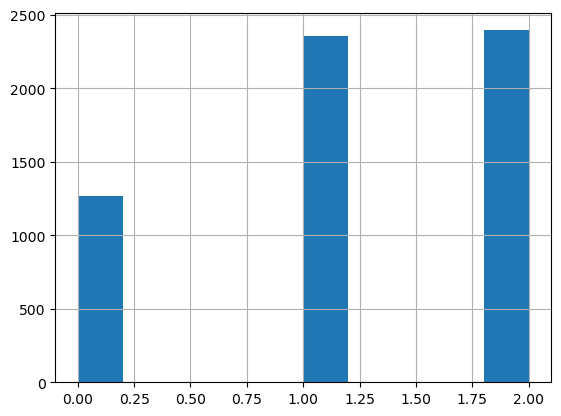

In [674]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(30, df)
df['Target'].hist()

In [675]:
import pandas_ta as pa
df["RSI"] = pa.rsi(df.Close, length=16)
df.tail(20)

,Local time,Open,High,Low,Close,Currency,signal,Target,RSI
6026,2023-02-07,19.1687,19.1792,18.8728,18.9067,USDMXN,0,NaN,46.849537
6027,2023-02-08,18.9067,18.9837,18.8252,18.9392,USDMXN,0,NaN,47.885878
6028,2023-02-09,18.9389,18.9960,18.7366,18.7712,USDMXN,0,NaN,43.237409
6029,2023-02-10,18.7709,18.8317,18.6395,18.6704,USDMXN,0,NaN,40.708312
6030,2023-02-13,18.6784,18.7289,18.5577,18.5713,USDMXN,0,NaN,38.355561
6031,2023-02-14,18.5719,18.6731,18.4986,18.5265,USDMXN,0,NaN,37.315602
6032,2023-02-15,18.5266,18.7505,18.5055,18.5856,USDMXN,0,NaN,39.619294
6033,2023-02-16,18.5857,18.6841,18.4804,18.5240,USDMXN,0,NaN,38.064038
6034,2023-02-17,18.5239,18.6756,18.3314,18.3717,USDMXN,0,NaN,34.493153
6035,2023-02-20,18.3962,18.4374,18.3318,18.3798,USDMXN,0,NaN,34.839935


In [676]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

              Open         High          Low        Close       signal  \
count  5998.000000  5998.000000  5998.000000  5998.000000  5998.000000   
mean     14.200639    14.280830    14.128715    14.202040     0.057019   
std       4.009869     4.050005     3.974839     4.009363     0.297424   
min       8.972000     9.002000     8.918500     8.970000     0.000000   
25%      10.903800    10.937600    10.865150    10.903700     0.000000   
50%      12.935500    13.004900    12.862850    12.935000     0.000000   
75%      18.671925    18.784975    18.574600    18.672100     0.000000   
max      25.358800    25.784900    24.682100    25.358800     2.000000   

            Target          RSI  
count  5998.000000  5998.000000  
mean      1.186229    50.070107  
std       0.757705    10.615564  
min       0.000000    21.065996  
25%       1.000000    42.522435  
50%       1.000000    49.161205  
75%       2.000000    57.276507  
max       2.000000    95.487443  


In [677]:
attributes = ['RSI', 'signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,RSI,Target,signalcategory_0,signalcategory_1,signalcategory_2
0,52.929293,2.0,1,0,0
1,50.172348,2.0,1,0,0
2,53.608983,2.0,1,0,0
3,57.750266,2.0,1,0,0
4,58.163584,1.0,1,0,0
...,...,...,...,...,...
5993,26.269657,0.0,1,0,0
5994,27.030068,0.0,1,0,0
5995,24.541219,0.0,1,0,0
5996,36.603737,2.0,1,0,0


In [678]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'signalcategory_0','signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.9 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

[16:55:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/amankrishna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/amankrishna/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


****Train Results****
Accuracy: 65.5243%
****Test Results****
Accuracy: 30.0000%


In [679]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[ 261  357  408]
 [  34 1542  582]
 [  24  456 1734]]
[[ 11 105 125]
 [  3  85 101]
 [  3  83  84]]
              precision    recall  f1-score   support

         0.0       0.82      0.25      0.39      1026
         1.0       0.65      0.71      0.68      2158
         2.0       0.64      0.78      0.70      2214

    accuracy                           0.66      5398
   macro avg       0.70      0.58      0.59      5398
weighted avg       0.68      0.66      0.64      5398

              precision    recall  f1-score   support

         0.0       0.65      0.05      0.09       241
         1.0       0.31      0.45      0.37       189
         2.0       0.27      0.49      0.35       170

    accuracy                           0.30       600
   macro avg       0.41      0.33      0.27       600
weighted avg       0.43      0.30      0.25       600

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


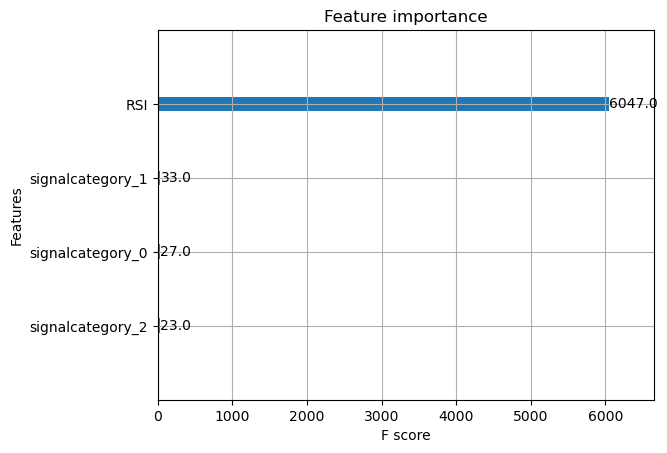

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


In [680]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)

In [681]:
import numpy as np

In [682]:
# split data into in-sample and out-of-sample data
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# train model on in-sample data
model = XGBClassifier()
model.fit(X_train, y_train)

# generate predictions on out-of-sample data
pred_test = model.predict(X_test)

# calculate accuracy on out-of-sample data
acc_test = accuracy_score(y_test, pred_test)
print('****Out-of-Sample Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

# generate confusion matrix and classification report for out-of-sample data
matrix_test = confusion_matrix(y_test, pred_test)
report_test = classification_report(y_test, pred_test)
print(matrix_test)
print(report_test)

[16:55:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/amankrishna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/amankrishna/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


****Out-of-Sample Test Results****
Accuracy: 30.0000%
[[ 11 105 125]
 [  3  85 101]
 [  3  83  84]]
              precision    recall  f1-score   support

         0.0       0.65      0.05      0.09       241
         1.0       0.31      0.45      0.37       189
         2.0       0.27      0.49      0.35       170

    accuracy                           0.30       600
   macro avg       0.41      0.33      0.27       600
weighted avg       0.43      0.30      0.25       600



<AxesSubplot:>

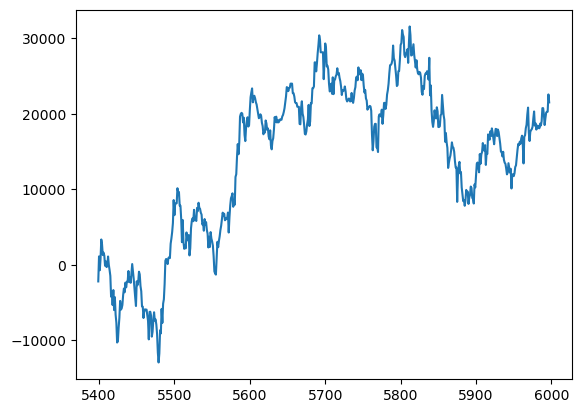

In [683]:
# generate PnLs based on out-of-sample data
df_test = df[train_pct_index:].copy()
df_test['Signal'] = np.where(pred_test == 1, -1*10000, np.where(pred_test == 2, 1*10000, 0))
df_test['PnL'] = df_test['Signal'] * df_test['Close'].diff()
cumulative_pnl = df_test['PnL'].cumsum()
cumulative_pnl.plot()

In [763]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

In [764]:
df = pd.read_excel('candlestick_data.xlsx', index_col=0, sheet_name='Sheet2')
df = df[df["Currency"] == "USDMXN"]
#conside dates between 2022-02-01 and 2023-03-01
# df = df.loc['2020-03-01':'2023-03-01']
df.columns = ['Open', 'High', 'Low', 'Close', 'Currency']
df.drop(['Currency','Open','High','Low'], axis=1, inplace=True)
df

,Close
Dates,
2000-01-03,9.5050
2000-01-04,9.5713
2000-01-05,9.5710
2000-01-06,9.5800
2000-01-07,9.5650
...,...
2023-02-28,18.3057
2023-03-01,18.1154
2023-03-02,18.1259


In [765]:
train_size = int(len(df) * 0.6)
train_data = df[:train_size]
test_data = df[train_size:]

In [766]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [767]:
seq_length = 60

def create_dataset(dataset, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(dataset)):
        X.append(dataset[i-seq_length:i])
        y.append(dataset[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = create_dataset(train_data_scaled, seq_length)
X_test, y_test = create_dataset(test_data_scaled, seq_length)

In [768]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [769]:
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/40
112/112 [==============================] - 5s 26ms/step - loss: 0.0167 - val_loss: 0.4987
Epoch 2/40
112/112 [==============================] - 3s 24ms/step - loss: 0.0197 - val_loss: 0.3082
Epoch 3/40
112/112 [==============================] - 3s 24ms/step - loss: 0.0168 - val_loss: 0.2400
Epoch 4/40
112/112 [==============================] - 3s 24ms/step - loss: 0.0122 - val_loss: 0.2133
Epoch 5/40
112/112 [==============================] - 3s 25ms/step - loss: 0.0096 - val_loss: 0.2069
Epoch 6/40
112/112 [==============================] - 3s 24ms/step - loss: 0.0087 - val_loss: 0.2057
Epoch 7/40
112/112 [==============================] - 3s 24ms/step - loss: 0.0083 - val_loss: 0.2032
Epoch 8/40
112/112 [==============================] - 3s 24ms/step - loss: 0.0079 - val_loss: 0.2009
Epoch 9/40
112/112 [==============================] - 3s 24ms/step - loss: 0.0076 - val_loss: 0.1996
Epoch 10/40
112/112 [==============================] - 3s 24ms/step - loss: 0.0073 - val_lo

In [770]:
y_pred = model.predict(X_test)

74/74 [==============================] - 1s 5ms/step


In [771]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])

In [772]:
y_pred.shape

(2359, 60)

In [773]:
y_test.shape

(2359, 1)

In [774]:
def backtest(y_true, y_pred):
    position = None
    pnl = []
    for i in range(len(y_true)-1):
        if y_pred[i][-1] > y_true[i]:
            if position is None:
                position = 'long'
                pnl.append(0)
            elif position == 'short':
                pnl.append(y_true[i+1] - y_true[i])
                position = 'long'
            else:
                pnl.append(0)
        elif y_pred[i][-1] < y_true[i]:
            if position is None:
                position = 'short'
                pnl.append(0)
            elif position == 'long':
                pnl.append(y_true[i] - y_true[i+1])
                position = 'short'
            else:
                pnl.append(0)
        else:
            pnl.append(0)
    return np.array(pnl)

In [775]:
pnl = backtest(y_test, y_pred)

/var/folders/js/d6m3lmg13x1dqjyw_1h8pr8h0000gn/T/ipykernel_38060/1498706083.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pnl)


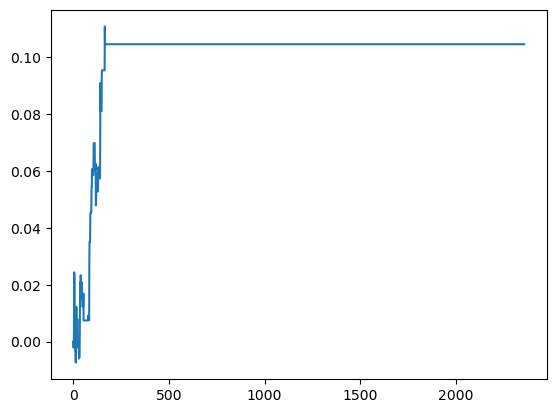

In [776]:
#plot pnl cumulative
plt.plot(np.cumsum(pnl))
plt.show()